### Exercise 1

![Image Title](assignment2.png)


In this assignment you will use the same imbalanced data set taken from MNIST as you did in 
Assignment #1. The t-SNE’d version of a randomy different version of similar data is shown above.
For this assignment you will
1) implement your own version of the Fuzzy C-Means clustering algorithm, “from scratch”.
2) you will apply this to both the dataset in the file (with 784 dimensions), as well as a PCA’d version of 
the data where you’ve reduced the dimensionality down to 2.
3) you will then write your own version of the Adjusted Rand Index algorithm (from scratch), and use it 
to score the results of your clustering on both versions of the data.
NOTE: you do not need to write PCA from scratch.
You will turn in both the code and a short report, discussing what you’ve implemented, how well it 
worked, what you’ve learned, etc. Remember, you must understand what you turn in – you may be 
asked to explain it to me and/or the class.
NOTE: Do not just comment your code and then turn that in as your report. I will deduct points. Your 
report will usually have at least a couple of pages of text, figures, etc

In [14]:
from bidict import bidict
from datetime import datetime
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn import datasets, metrics

google = False
data_path = 'G:/My Drive/csc730'

In [15]:
# %matplotlib qt

In [16]:
if google == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !ls "/content/drive/"

In [17]:
X_y = np.load('../data/skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape,y.shape)

(12244, 784) (12244,)


probability=array([0.01559948, 0.00187847, 0.03128063, 0.50073505, 0.25032669,
       0.0077589 , 0.06256125, 0.0008984 , 0.00383861, 0.12512251]) bins=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) counts=array([ 191,   23,  383, 6131, 3065,   95,  766,   11,   47, 1532],
      dtype=int64)


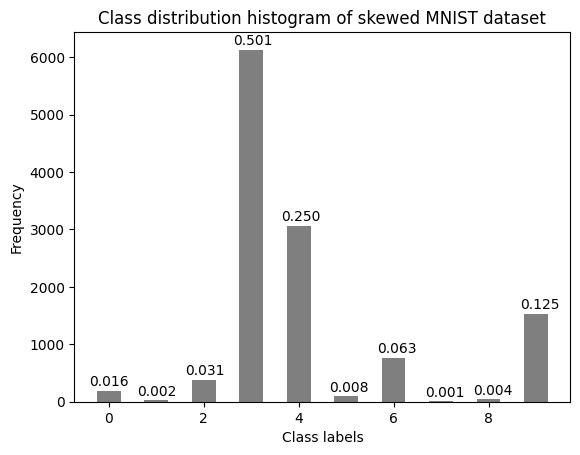

In [18]:
#original
#plt.hist(y)
#plt.xlabel('Class labels')
#plt.ylabel('frequency')

#modified qqqxxx
plt.hist(y, bins=np.linspace(0,10,11), align='left', rwidth=0.5, color='black', alpha=0.5)
plt.xlabel('Class labels')
plt.ylabel('Frequency')
plt.title('Class distribution histogram of skewed MNIST dataset')

probability, bins = np.histogram(y, bins=np.linspace(0,10,11), density=True)
counts, bins = np.histogram(y, bins=np.linspace(0,10,11))

print(f'{probability=} {bins=} {counts=}')

for i in range(len(probability)):
    plt.text(bins[i]+i/100, counts[i]+30, f'{probability[i]:.3f}', ha='center', va='bottom')

plt.savefig('class_histogram.png', dpi=300)
plt.show()


In [19]:
print(f'{X[1]=}')
print(f'{X[2]=}')
print(np.linalg.norm(X[1]-X[2]))
print(distance.euclidean(X[1],X[2]))


X[1]=array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0

Implement fuzzy-cmeans from scratch

The paper this will be implmented from is titled: 'A Survey of Clustering Algorithms for Big Data: Taxonomy and Empirical Analysis'


[1]  
FCM pseudo-code:  
Input: Given the dataset, set the desire number of clusters c, the fuzzy parameter m (a constant > 1), and the stopping condition, initialize the fuzzy partition matrix, and set stop = false.  
Step 1. Do:  
Step 2. Calculate the cluster centroids and the objective value J.  
$\LARGE{v_{k}=\frac{\sum_{i=1}^n{{\mu^{m}_{{i}{k}}{\bold{\underline{p_{i}}}}}}}{\sum_{i=1}^n{{\mu^{m}_{{i}{k}}}}}}$ 
   
     
$\LARGE{{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{k}}}\vert}=\sqrt{\sum_{i=1}^{n}{(\bold{\underline{x_{i}}}-\bold{\underline{v_{k}}})^2}}}$  
  

$\LARGE{J=\sum_{i=1}^{n}{\sum_{k=1}^{c}{\mu^{m}_{{i}{k}}{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{k}}}\vert^{2}}}}}$  
  

Step 3. Compute the membership values stored in the matrix.  

$\LARGE{{\mu^{m}_{{i}{k}}}=\frac{1}{\sum_{l=1}^{c}{(\frac{{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{k}}}\vert^{2}}}{{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{l}}}\vert^{2}}})}^{\frac{2}{m-1}}}}$
  
    
Step 4. If the value of J between consecutive iterations is less than the stopping condition, then stop = true.  
Step 5. While (!stop)  
Output: A list of c cluster centres and a partition matrix are produced.  
  
References:
[1] Fahad, A., Alshatri, N., Tari, Z., Alamri, A., Khalil, I., Zomaya, A. Y., ... & Bouras, A. (2014). A survey of clustering algorithms for big data: Taxonomy and empirical analysis. IEEE transactions on emerging topics in computing, 2(3), 267-279.

In [20]:
# Implment fuzzy c-means clustering from scratch

def generate_mu(p, n_clusters, random_state=42):
    np.random.seed(random_state)
    #U = np.random.rand(p.shape[0],n_clusters)
    U = np.random.uniform(low=0.25, high=1, size=(p.shape[0], n_clusters))
    U = np.array([U[i,:] / np.sum(U[i,:], axis=0) for i in range(U.shape[0])])
    return U

def update_mu(p, mu, v,  m):
    for i in range(p.shape[0]):
        for k in range(mu.shape[1]):
             mu[i,k] = 0
             numerator = np.linalg.norm(p[i,:]-v[k,:])
             for l in range(mu.shape[1]):
                 denominator = np.linalg.norm(p[i,:]-v[l,:])
                 mu[i,k] += np.float_power(numerator/denominator,(2/(m-1)))
             mu[i,k] = 1 / mu[i,k]
                           
    return mu
   

def calculate_v(p, mu, m):
    v =  np.zeros(shape = (mu.shape[1], p.shape[1]))
    
    for k in range(mu.shape[1]):
        numerator = np.zeros((1, p.shape[1]))           
        for i in range(p.shape[0]):          
            numerator += np.float_power(mu[i,k],m) * p[i,:]
        denominator = np.sum(np.float_power(mu[:,k],m))
        v[k,:] = numerator / denominator
    return v

def calculate_J(p, mu, v, m):    
    j = 0
    for i in range(p.shape[0]):
        for k in range(mu.shape[1]):
            j += np.float_power(mu[i,k],m) * np.float_power(np.linalg.norm(p[i,:]-v[k,:]),2)
    
    return j


def fcm(p, n_clusters, max_iter=100, m=2, error=1e-5, random_state=42):
    #initialize u
    #step 0
    iterations = 0
    mu = generate_mu(p, n_clusters, random_state)
    stop = 1+error
    j = [0]
    iteration_time = []
    #step 1 
    
    while stop >= error and iterations < max_iter: #stopping condition
        #step 2
        start_time = datetime.now() 
        v = calculate_v(p, mu, m) #calculate centroid clusters
        mu =  update_mu(p, mu, v, m)
        j.append( calculate_J(p, mu, v, m) ) #calculate objective function        
        #step 3
        
        iteration_time.append(datetime.now() - start_time)
        stop = np.abs(j[-1] - j[-2]) #calculate stopping condition        
        print(f'iteration {iterations} took {iteration_time[-1]} seconds, stop = {stop:.1f}, j = {j[-1]:.1f}')
        iterations += 1
      
    return mu, v, j, iteration_time



In [21]:
#Apply fuzzy c-means this to both the dataset in the file (with 784 dimensions), as well as a PCA’d version of the data where you’ve reduced the dimensionality down to 2.
#we can use the PCA function from sklearn.decomposition to reduce the dimensionality of the data down to 2 dimensions.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)

#plot the results of the clustering on the original data and the PCA’d data, and compare the results.

pca_mu, pca_v, pca_j, pca_iteration_time  = fcm(X_pca, 10, max_iter=100, m=2, error=1, random_state=42)
full_mu, full_v, full_j, full_iteration_time = fcm(X, 10, max_iter=10, m=2, error=1, random_state=42)



(12244, 2)
iteration 0 took 0:00:09.113961 seconds, stop = 95508.2, j = 95508.2
iteration 1 took 0:00:09.556591 seconds, stop = 5.7, j = 95502.5
iteration 2 took 0:00:09.238368 seconds, stop = 33.1, j = 95469.4
iteration 3 took 0:00:09.221636 seconds, stop = 195.9, j = 95273.5
iteration 4 took 0:00:09.558120 seconds, stop = 1098.3, j = 94175.2
iteration 5 took 0:00:10.206657 seconds, stop = 4622.9, j = 89552.3
iteration 6 took 0:00:11.056638 seconds, stop = 8392.5, j = 81159.7
iteration 7 took 0:00:10.060634 seconds, stop = 5818.4, j = 75341.3
iteration 8 took 0:00:09.822882 seconds, stop = 4512.6, j = 70828.7
iteration 9 took 0:00:09.585510 seconds, stop = 5491.8, j = 65336.9
iteration 10 took 0:00:09.388802 seconds, stop = 4948.6, j = 60388.3
iteration 11 took 0:00:09.672897 seconds, stop = 3207.2, j = 57181.1
iteration 12 took 0:00:09.914534 seconds, stop = 1893.2, j = 55287.9
iteration 13 took 0:00:09.858042 seconds, stop = 1174.3, j = 54113.6
iteration 14 took 0:00:09.711682 secon

Text(0.5, 1.0, 'Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')

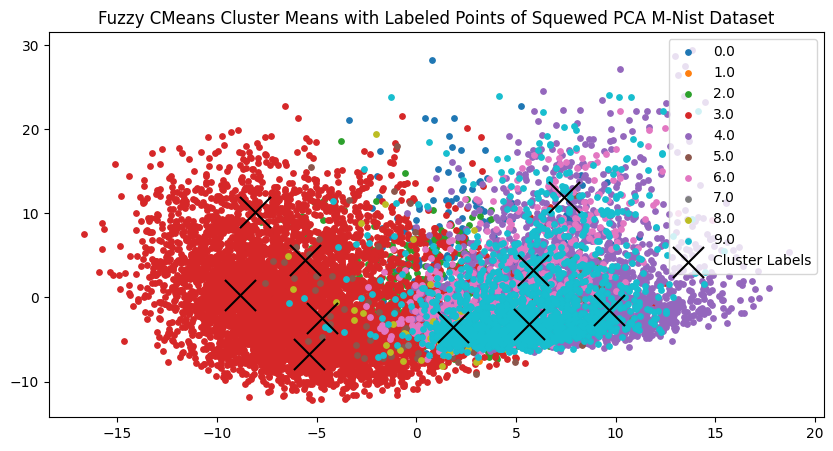

In [24]:
clusters = np.unique(y)

plt.figure(figsize=(10, 5))
for cl_num in np.unique(clusters):
    inds = np.where(y == cl_num)[0]
    plt.scatter(X_pca[inds,0],X_pca[inds,1], marker = 'o', s = 15, label = cl_num)

plt.scatter(pca_v[:, 0], pca_v[:,1], marker='x', c= 'black', s=500, label='Cluster Labels')
plt.legend()
plt.title('Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')


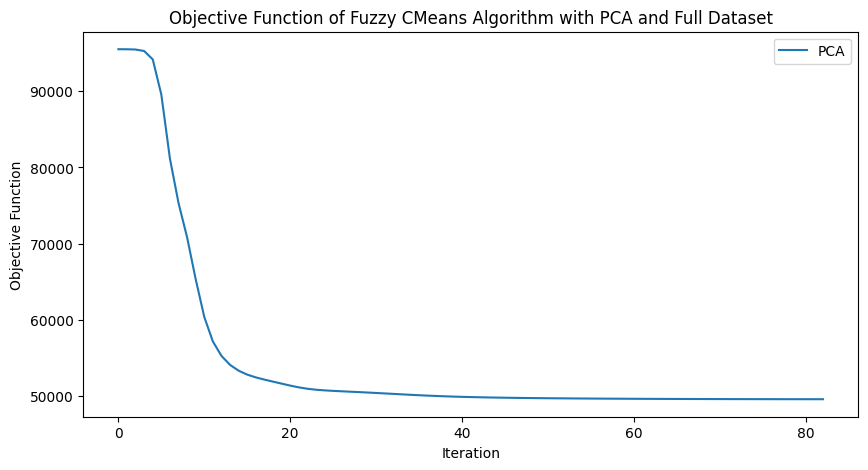

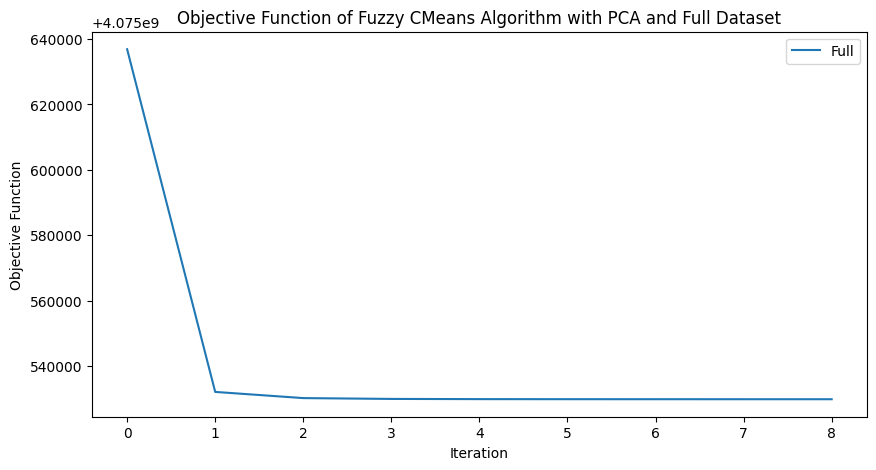

In [30]:
#plot pca_j and full_j

plt.figure(figsize=(10, 5))
plt.plot(pca_j[1:], label='PCA')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(full_j[1:], label='Full')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')
plt.show()



h:\dev\git\csc730\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


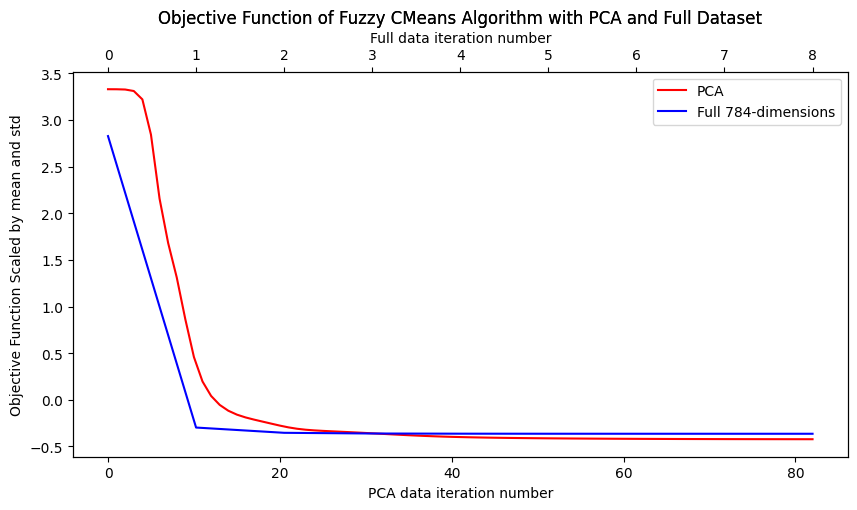

In [68]:
from sklearn.preprocessing import scale
#let's generate a twiny plot with the iteration time
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(scale(pca_j[1:], axis=0, with_mean=True, with_std=True), label='PCA', color='red')
ax1.set_xlabel('PCA data iteration number')
ax1.set_ylabel('Objective Function Scaled by mean and std')
#ax1.legend()

ax1.set_title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')

ax2 = ax1.twiny()
ax2.plot(scale(full_j[1:],axis=0, with_mean=True, with_std=True), label='Full 784-dimensions', color='blue')
ax2.set_xlabel('Full data iteration number')
ax2.set_ylabel('Objective Function Scaled by mean and std')
#axis x_ticks_labels needs to be replaced to go from 0 to 1



lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax2.set_title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')
plt.show()


In [36]:
#you will then write your own version of the Adjusted Rand Index algorithm (from scratch), and use it to score the results of your clustering on both versions of the data.
#The Adjusted Rand Index is a measure of the similarity between two data clusterings, and is often used to compare the results of clustering algorithms to a ground truth clustering.

def adjusted_rand_index(y, y_pred):    
   '''
    Function defined to calculate the Rand Index. This algorithm determines
    the simularities and differences in which points are either within the same cluster
    or not and compares both the true labels and predicted labels. This is required because
    predicted clusters are not assumed to be consistent.
    
    Inputs:
    
    y: True Labels
    y_pred: Predicted Labels
    
    '''
    
    # Initialize comparison values
   n_00 = 0.
   n_11 = 0.
   n_10 = 0.
   n_01 = 0.

   # Initialize comparison matrices
   true = np.zeros((len(y), len(y)))
   pred = np.zeros((len(y), len(y)))

   # Iterate through labels
   for i in range(true.shape[0]):
       # Iterate through labels
       for j in range(true.shape[0]):
           # Check if points in true labels are in same cluster
           if(y[i] == y[j]):
               true[i,j] = 1
            
            # Check if points in predicted labels are in same cluster
           if(y_pred[i] == y_pred[j]):
               pred[i,j] = 1

    # Iterate through upper triangular of true and predicted comparison matrix
   for i in range(true.shape[0]):
       for j in range(i+1, true.shape[1]):
           # Check if true index value is same as predicted index value
           if(true[i,j] == pred[i,j]):
               # Both are in same cluster 
               if(true[i,j] == 1):
                   n_11 += 1.
               # Both are not in same cluster
               else:
                   n_00 += 1.
           # Index values are not the same        
           else:
               # Same clusters in true but different clusters in pred
               if(true[i,j] == 1):
                   n_10 += 1.
               # Different clusters in true but same clusters in pred
               else:
                   n_01 += 1.
    # Calculate rand index value
   ari = (n_00 + n_11) / (n_00 + n_11 + n_10 + n_11)

   return ari


#use the adjusted_rand_index function to score the results of your clustering on both versions of the data.
RI_full = adjusted_rand_index(y, np.argmax(full_mu, axis=1))
RI_pca= adjusted_rand_index(y, np.argmax(pca_mu, axis=1))
print(f'RI of original data: {RI_full:.3f}')
print(f'RI of PCA data: {RI_pca:.3f}')




RI of original data: 0.692
RI of PCA data: 0.672


In [86]:
from scipy.signal import find_peaks

def psd_peaks(X, height=0, threshold=0, distance=36, dc_offset=20, peak_count=4):
    #pad data for 2^n requirement of FFT
    X1 = np.pad(X, ((0, 0), (0,252)), 'constant')
    
    #calculate FFT and PSD
    FFT_all=np.array([np.fft.fft(X1[i][0:1024]) for i in range(X1.shape[0])])
    PSD_all = np.abs(FFT_all)**2    

    peaks_list = []
    peak_values_list = []

    for i in range(X1.shape[0]):        
        # min-max standardization
        data = PSD_all[i][0:512]   
        data = data - np.mean(data)
        data = data / np.std(data)

        peaks = find_peaks(data[dc_offset:], height = height, threshold=threshold, distance=distance)
 
        peak_values = np.array([peaks[1]['peak_heights'][i] for i in range(peaks[0].shape[0])])
        peaks = peaks[0]+dc_offset

        #choose the top peak_count peaks
        peak_values_list.append( peak_values[np.argsort(peak_values)[:peak_count]][::-1])
        peaks_list.append( peaks[np.argsort(peak_values)[:peak_count]][::-1])

    return peaks_list, peak_values_list

In [90]:
import scipy.stats as stats

Npeaks = 10
X_psd_peaks, X_peak_peak_values = psd_peaks(X, peak_count = Npeaks)

#review x_psd_peaks and x_peak_peak_values
#set all entries to length Npeaks
#when there are less than Npeaks peaks, set the rest to 0
for i in range(len(X_psd_peaks)):
    if len(X_psd_peaks[i]) < Npeaks:
        X_psd_peaks[i] = np.pad(X_psd_peaks[i], (0, Npeaks-len(X_psd_peaks[i])), 'constant')
        X_peak_peak_values[i] = np.pad(X_peak_peak_values[i], (0, Npeaks-len(X_peak_peak_values[i])), 'constant')
        
X_psd_peaks = np.array(X_psd_peaks)
X_peak_peak_values = np.array(X_peak_peak_values)
#hstack the peaks and peak values
X_psd_peaks_and_values = np.hstack(X_psd_peaks, X_peak_peak_values)


print(f'{X_psd_peaks.shape=}, {X_peak_peak_values.shape=}')
psd_mu, psd_v, psd_j, psd_iteration_time  = fcm(X_psd_peaks_and_values, 10, max_iter=100, m=2, error=1, random_state=42)

RI_psd = adjusted_rand_index(y, np.argmax(psd_mu, axis=1))


X_psd_peaks.shape=(12244, 10), X_peak_peak_values.shape=(12244, 10)
iteration 0 took 0:00:10.883701 seconds, stop = 94058179.5, j = 94058179.5
iteration 1 took 0:00:10.843949 seconds, stop = 2392.8, j = 94055786.7
iteration 2 took 0:00:10.768844 seconds, stop = 6819.8, j = 94048966.9
iteration 3 took 0:00:10.718910 seconds, stop = 24771.4, j = 94024195.5
iteration 4 took 0:00:10.798199 seconds, stop = 89642.9, j = 93934552.6
iteration 5 took 0:00:10.970672 seconds, stop = 316708.7, j = 93617844.0
iteration 6 took 0:00:10.760489 seconds, stop = 1035597.0, j = 92582247.0
iteration 7 took 0:00:10.741327 seconds, stop = 2676408.8, j = 89905838.1
iteration 8 took 0:00:10.842761 seconds, stop = 4018607.9, j = 85887230.2
iteration 9 took 0:00:10.585624 seconds, stop = 3347759.1, j = 82539471.2
iteration 10 took 0:00:10.727101 seconds, stop = 3175672.4, j = 79363798.7
iteration 11 took 0:00:10.629582 seconds, stop = 4833514.9, j = 74530283.8
iteration 12 took 0:00:11.033632 seconds, stop = 771

In [91]:
print(f'RI of PSD data: {RI_psd:.3f}')

RI of PSD data: 0.665


Text(0.5, 1.0, 'Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')

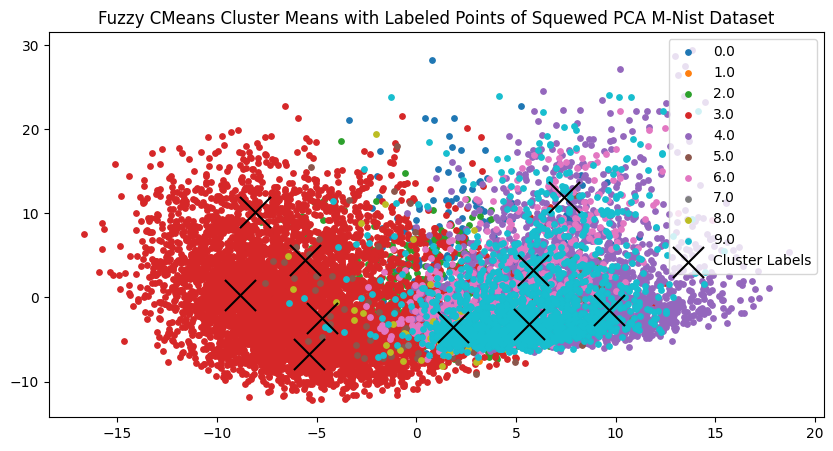

In [ ]:
clusters = np.unique(y)

plt.figure(figsize=(10, 5))
for cl_num in np.unique(clusters):
    inds = np.where(y == cl_num)[0]
    plt.scatter(X_pca[inds,0],X_pca[inds,1], marker = 'o', s = 15, label = cl_num)

plt.scatter(pca_v[:, 0], pca_v[:,1], marker='x', c= 'black', s=500, label='Cluster Labels')
plt.legend()
plt.title('Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')
